In [1]:
import time
import yaml
import numpy as np
from SimuQ.thesis.Experiment.utilities.hamiltonian_models import Ising
from SimuQ.thesis.Experiment.utilities.evaluation_metrics import TV
from simuq.qutip import QuTiPProvider
import logging.config
import logging

# Make this configurable parameters for the script
########################################################################################################################
N = 4
T = 1
system = "ibmq_mumbai"
noise_factor = 0

#Setup logger
with open('../../experiments/logging.yaml', encoding="utf8") as ly:
    loggingDict = yaml.safe_load(ly)
logging.config.dictConfig(loggingDict)
logger = logging.getLogger("optimization_level_experiment")

########################################################################################################################
# Ising chain model creation

h = np.array([1 for j in range(N)])
J_chain = np.zeros((N, N))
for j in range(N - 1):
    J_chain[j, j + 1] = 1

J_cycle = np.copy(J_chain)
J_cycle[0, N - 1] = 1

# On the IBM devices, only Ising_chain has a solution, therefore keeping it
logger.info("Creating the model with {} qubits and simulation time to be: {} units".format(N, T))
Ising_chain = Ising(N, T, J_chain, h)
# Ising_cycle = Ising(N, T, J_cycle, h)

########################################################################################################################
# Classical simulation for comparison

qtpp = QuTiPProvider()
qtpp.compile(Ising_chain)
qtpp.run()
res_chain_gt = qtpp.results()

########################################################################################################################
# Experiment run

from ibm_provider_custom import IBMProvider
ibm = IBMProvider(from_file="../ibm_API_key", hub="ibm-q-ncsu", group="nc-state", project="quantum-compiler")
ibm.compile(Ising_chain, backend=system, trotter_num=4, use_pulse=True, noise_factor=0)

Compiled.
Solved.


In [85]:
from qiskit import QuantumCircuit, transpile
from qiskit_transpiler import get_pm

backend = ibm.provider.get_backend("ibmq_mumbai")
n = backend.configuration().n_qubits

pm = get_pm(backend)
circ = ibm.prog

cal_circs = []
cal = circ.calibrations

#Just created the circuit with one gate
#TODO: Can also create the circuit with more than one gate, similar to Rabi experiments
def create_rzx_cal_circ(init_state,angle,qubit1,qubit2):
    qc = QuantumCircuit(n,2)
    qc.initialize(init_state,[qubit1, qubit2])
    qc.rzx(angle,qubit1,qubit2)
    qc.rzx(-angle,qubit1,qubit2)
    qc.measure([qubit1, qubit2],[0,1])
    return qc

def create_rx_cal_circ(init_state,angle,qubit):
    qc = QuantumCircuit(n,2)
    qc.initialize(init_state,[qubit])
    qc.rx(angle,qubit)
    qc.rx(-angle,qubit)
    qc.measure([qubit],[0])
    return qc

rzx_cal_circs = []
rx_cal_circs = []

if 'rzx' in cal:
    for qubits,params in cal['rzx']:

        #Create calibrations for different inputs
        #TODO: add + and - as well afterwards
        #Number of circuits per instruction: 4
        for i in ['0','1']:
            for j in ['0','1']:
                init_state = i + j
                rzx_cal_circs.append(transpile(pm.run(create_rzx_cal_circ(init_state,params[0],qubits[0],qubits[1]))))

if 'rx' in cal:
    for qubit,params in cal['rx']:

        #Create calibrations for different inputs
        #TODO: add + and - as well afterwards
        #Number of circuits per instruction: 4
        for init_state in ['0','1']:
            rx_cal_circs.append(transpile(pm.run(create_rx_cal_circ(init_state,params[0],qubit[0]))))

cal_circs = rzx_cal_circs + rx_cal_circs

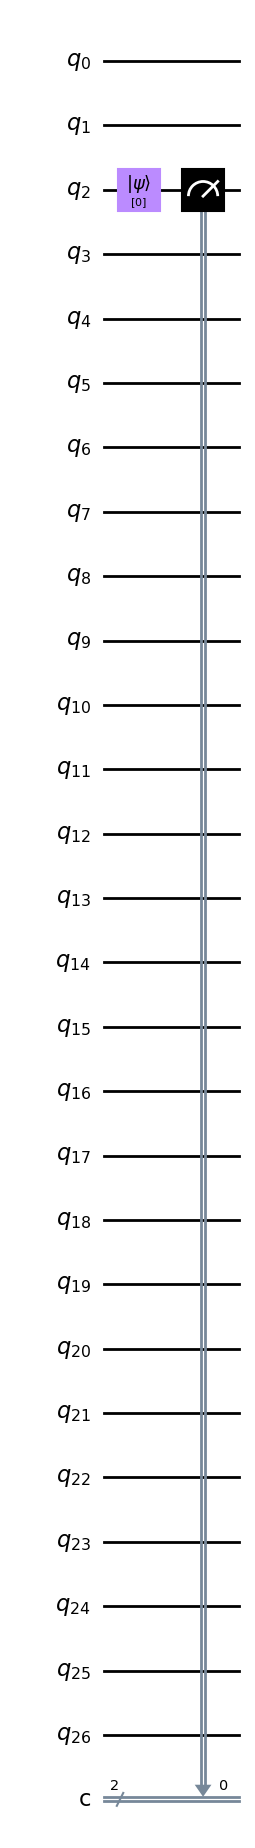

In [96]:
rx_cal_circs[6].draw("mpl")